# COURSE: A deep understanding of deep learning
## SECTION: More on data
### LECTURE: Data noise augmentation (with devset+test)
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202208

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# A function that returns a dataset with a specified size

In [18]:
# import dataset (comes with colab!)
dataFull = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# normalize the data to a range of [0 1]
dataFull[:,1:] = dataFull[:,1:] / np.max(dataFull)


# now for the function
def makeTheDataset(N,doubleTheData=False):

  # extract labels (number IDs) and remove from data
  data   = dataFull[:N,1:]
  labels = dataFull[:N,0]


#   make a noisy copy of ALL the data
#   if doubleTheData:
#     dataN  = data + np.random.random_sample(data.shape)/2
#     data   = np.concatenate((data,dataN),axis=0)
#     labels = np.concatenate((labels,labels),axis=0)


  # convert to tensor
  dataT   = torch.tensor( data   ).float()
  labelsT = torch.tensor( labels ).long()

  # use scikitlearn to split the data
  train_data,devset_data, train_labels,devset_labels = train_test_split(dataT, labelsT, train_size=.9)


  # make a noisy copy of the TRAIN data
  if doubleTheData:
    train_dataN  = train_data + torch.rand_like(train_data)/2
    train_data   = torch.cat((train_data,train_dataN),axis=0)
    train_labels = torch.cat((train_labels,train_labels),axis=0)
  

  # convert into PyTorch Datasets
  train_data  = TensorDataset(train_data,train_labels)
  devset_data = TensorDataset(devset_data,devset_labels)

  # translate into dataloader objects
  batchsize     = 20
  train_loader  = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  devset_loader = DataLoader(devset_data,batch_size=devset_data.tensors[0].shape[0])



  # NEW!! Create a test set (don't need a dataloader)
  testdata   = torch.tensor( dataFull[N:,1:] ).float()
  testlabels = torch.tensor( dataFull[N:,0]  ).long()

  return train_loader,devset_loader,(testdata,testlabels)

In [19]:
dataFull.shape

(20000, 785)

In [20]:
dataFull[:100,1:].shape

(100, 784)

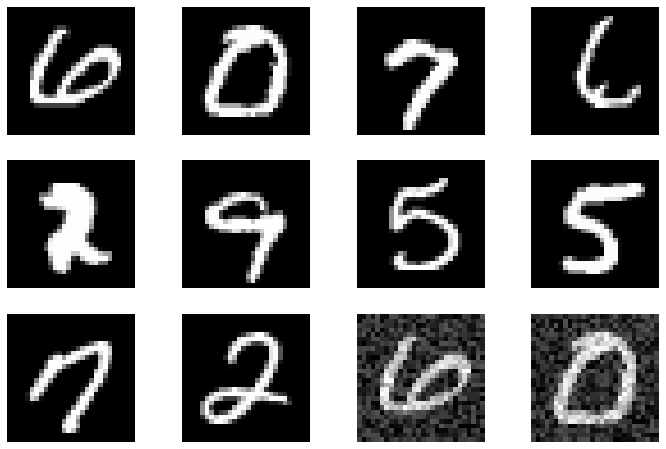

In [21]:
# visualize the images

# get some sample data
train_loader,devset_loader,testdataset = makeTheDataset(12,True)

# pop out the data matrices
img = train_loader.dataset.tensors[0].detach()

# show the numbers
fig,ax = plt.subplots(3,4,figsize=(12,8))
for i,ax in enumerate(ax.flatten()):
  ax.imshow(np.reshape(img[i,:],(28,28)) ,cmap='gray')
  ax.axis('off')
plt.show()

# Create the DL model

In [22]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)
      
      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
  
  # create the model instance
  net = mnistNet()
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

# Create a function that trains the model

In [23]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 50
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  devsetAcc = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # devset accuracy
    X,y = next(iter(devset_loader)) # extract X,y from devset dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    devsetAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,devsetAcc,losses,net

# Run an experiment showing better performance with increased N



In [24]:
# takes ~3 mins

# list of data sample sizes
samplesizes = np.arange(500,4001,500)

# initialize results matrix
resultsSingle = np.zeros((len(samplesizes),3))
resultsDouble = np.zeros((len(samplesizes),3))


for idx,ssize in enumerate(samplesizes):

  ### without doubling the data!

  # generate a dataset and train the model
  train_loader,devset_loader,testdataset = makeTheDataset(ssize,False)
  trainAcc,devsetAcc,losses,net = function2trainTheModel()

  # grab the results
  resultsSingle[idx,0] = np.mean(trainAcc[-5:])
  resultsSingle[idx,1] = np.mean(devsetAcc[-5:])
  resultsSingle[idx,2] = torch.mean(losses[-5:]).item()




  ### with doubling the data!

  # generate a dataset and train the model
  train_loader,devset_loader,testdataset = makeTheDataset(ssize,True)
  trainAcc,devsetAcc,losses,net          = function2trainTheModel()

  # grab the results
  resultsDouble[idx,0] = np.mean(trainAcc[-5:])
  resultsDouble[idx,1] = np.mean(devsetAcc[-5:])
  resultsDouble[idx,2] = torch.mean(losses[-5:]).item()


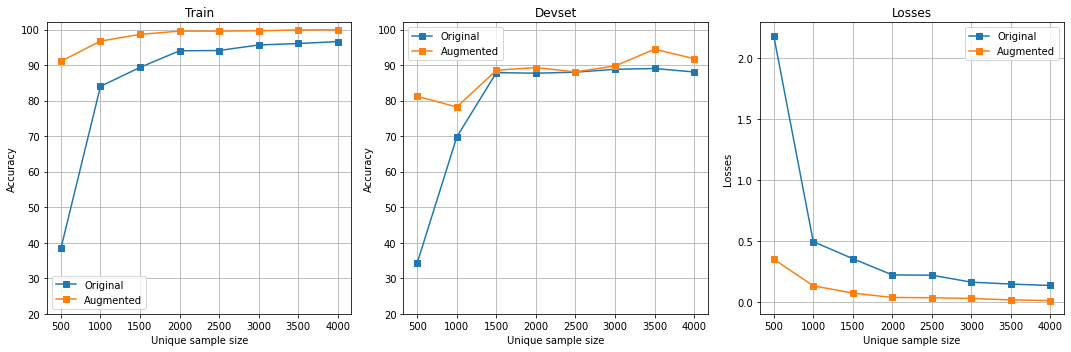

In [25]:
# Let's see what the results look like!

fig,ax = plt.subplots(1,3,figsize=(15,5))

# axis and title labels
titles    = ['Train','Devset','Losses']
yaxlabels = ['Accuracy','Accuracy','Losses']

# common features
for i in range(3):

  # plot the lines
  ax[i].plot(samplesizes,resultsSingle[:,i],'s-',label='Original')
  ax[i].plot(samplesizes,resultsDouble[:,i],'s-',label='Augmented')
  
  # make it look nicer
  ax[i].set_ylabel(yaxlabels[i])
  ax[i].set_title(titles[i])
  ax[i].legend()
  ax[i].set_xlabel('Unique sample size')
  ax[i].grid('on')

  if i<2:
    ax[i].set_ylim([20,102])


plt.tight_layout()
plt.show()

# Now for test accuracy!

In [26]:
# we need to re-run the models for N=500

samplesize = 500

train_loader,devset_loader,testdataset  = makeTheDataset(samplesize,False)
trainAccO,devsetAccO,lossesO,netO       = function2trainTheModel() # O = original

train_loader,devset_loader,testdataset  = makeTheDataset(samplesize,True)
trainAccA,devsetAccA,lossesA,netA       = function2trainTheModel() # A = augmented

In [27]:
# Now for the real test! On the test data!

# extract the test data
X,y = testdataset

# run the original model
yHat = netO(X)
testO = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

# And the augmented model
yHat = netA(X)
testA = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())

# print the results!
print( f'ORIGINAL MODEL (N={samplesize}):\n  Train: {trainAccO[-1]:.2f}%, devset: {devsetAccO[-1]:.2f}%, test: {testO:.2f}%\n\n')
print(f'AUGMENTED MODEL (N={samplesize}):\n  Train: {trainAccA[-1]:.2f}%, devset: {devsetAccA[-1]:.2f}%, test: {testA:.2f}%')


ORIGINAL MODEL (N=500):
  Train: 30.68%, devset: 34.00%, test: 27.06%


AUGMENTED MODEL (N=500):
  Train: 90.78%, devset: 72.00%, test: 74.70%


# Additional explorations

In [10]:
# 1) It looks like noise augmentation only helped for small sample sizes (<1000). Write code to run a new experiment that
#    reproduces this experiment 10 times, but only using sample sizes [500,1000,2000]. Then make a plot showing the increase
#    in devset accuracy for all 10 runs. That will help determine whether our finding above was a quirk of sampling 
#    variability or a meaningful effect.
# 
# 2) Immediately after loading in the MNIST data (top of the script), there is the following code:
#    dataFull[:,1:] = dataFull[:,1:] / np.max(dataFull)
#    This is different from the corresponding normalization code in the previous MNIST videos. Do you need the [:,1:]?
#    What happens when you change that line to: dataFull = dataFull / np.max(dataFull)
#    Can you still train the model?
# 
# 3) We augmented the data using noisy copies. Another idea is to augment the dataset using color-flipped copies. Thus,
#    the numbers will be black on a white background. Try it and see how the results compare to the noise-added version!
# 